In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_ftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473332e+08,5.094727e+06,8.082051e+02,5.028689e-01,4.028818e-01,9.854712e-02,3.752564e-01,5.918652e-02,4.195026e-01,1.184329e-01,...,1.145499e-02,1.968431e-02,7.960149e-02,1.344227e-01,9.530649e-03,1.751597e-02,8.878922e-02,7.431632e-02,3.897225e-02,5.331061e-02
std,9.952986e+07,7.972087e+06,2.292125e+03,4.710872e-01,4.523492e-01,2.907154e-01,4.479614e-01,2.284392e-01,2.256374e-01,7.151420e-02,...,5.399123e-02,8.007008e-02,1.179461e-01,1.749526e-01,5.258238e-02,8.241773e-02,1.050750e-01,9.861962e-02,9.868933e-02,1.123964e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.926878e+07,4.672090e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.368196e+08,1.634092e+06,1.990000e+02,6.774194e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433434e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,5.416341e-02,3.541864e-02,0.000000e+00,0.000000e+00
75%,2.260676e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.390244e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.860562e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,1.365586e-01,1.118571e-01,0.000000e+00,4.670041e-02
max,3.617734e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [5]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.7022064651322837


### Sample only PRs by first-time contributors

In [6]:
# Filters data
df = df[df[ftc_key] == True]
df = df.drop([ftc_key], axis=1)
independent_fields.remove(ftc_key)
print(f"{len(df)=}")

# Recalculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

# Resets indices.
df = df.reset_index(drop=True)
print(independent_fields)

df.describe()

len(df)=426950
class_imbalance=1.9249761932491591
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosy

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,4.269500e+05,4.269500e+05,426950.000000,426950.0,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,...,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000
mean,1.213611e+08,5.135208e+06,583.468856,0.0,0.265369,0.023942,0.256556,0.024850,0.491555,0.106444,...,0.002773,0.004925,0.057730,0.094629,0.004179,0.007882,0.041580,0.031869,0.011340,0.015214
std,9.542074e+07,8.019043e+06,1718.982599,0.0,0.409419,0.149572,0.405455,0.150642,0.223162,0.061022,...,0.025500,0.040188,0.101410,0.149802,0.033544,0.054342,0.075893,0.067568,0.048302,0.055133
min,1.153000e+03,1.000000e+00,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.800664e+07,4.989098e+05,30.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.334494,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.010847e+08,1.681994e+06,122.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.503086,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.890214e+08,6.317507e+06,470.000000,0.0,0.666667,0.000000,0.650000,0.000000,0.662209,0.119279,...,0.000000,0.000000,0.089382,0.155067,0.000000,0.000000,0.053404,0.031890,0.000000,0.000000
max,3.617726e+08,5.973444e+07,82976.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.759557,1.000000,1.000000,1.000000,1.000000,0.999543,0.905874,0.880496,0.741177,0.756834


## Model Creation

In [7]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


### Full Model

In [8]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43
random_state=43
random_state=43
random_state=43
random_state=43
metrics={'accuracy': 0.7695163368075887, 'precision': 0.7939233390944774, 'recall': 0.876538146021329, 'f1': 0.8331878321453091}

Confusion matrix:
[[16558 12758]
 [ 6923 49151]]

Classification report:
              precision    recall  f1-score   support

       False       0.71      0.56      0.63     29316
        True       0.79      0.88      0.83     56074

    accuracy                           0.77     85390
   macro avg       0.75      0.72      0.73     85390
weighted avg       0.76      0.77      0.76     85390

metrics={'accuracy': 0.7671858531443962, 'precision': 0.7922759957986588, 'recall': 0.8746766568548747, 'f1': 0.8314397151093775}

Confusion matrix:
[[16480 12855]
 [ 7025 49030]]

Classification report:
metrics={'accuracy': 0.7677831127766718, 'precision': 0.7934192071450451, 'recall': 0.8752445313889383, 'f1': 0.8323256580894478}

Confusion matrix:
[[16346 12814]
 [ 7015 49215]]

Class

### Control + Intra-project Model

In [9]:
from python_proj.utils.util import get_matching

ci_re = r".*(Control|Intra).*"
contr_with_intra = list(get_matching(independent_fields, ci_re))
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45random_state=45

random_state=45random_state=45
random_state=45

metrics={'accuracy': 0.7377795994847172, 'precision': 0.7792859397584356, 'recall': 0.8374276940655574, 'f1': 0.8073113430806433}

Confusion matrix:
[[16093 13285]
 [ 9106 46906]]

Classification report:
              precision    recall  f1-score   support

       False       0.64      0.55      0.59     29378
        True       0.78      0.84      0.81     56012

    accuracy                           0.74     85390
   macro avg       0.71      0.69      0.70     85390
weighted avg       0.73      0.74      0.73     85390

metrics={'accuracy': 0.7369246984424406, 'precision': 0.7795372306875146, 'recall': 0.836462081003099, 'f1': 0.8069970444704103}

Confusion matrix:
[[15962 13282]
 [ 9182 46964]]

Classification report:
              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29244
        True       0.78      0.84      0.81     56146

    accuracy          

### Collaboration and Ecosystem Model

In [10]:
from python_proj.utils.util import get_non_matching

non_control_intra_fields = list(get_non_matching(independent_fields, ci_re))
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + DependencyEcosystem

random_state=47random_state=47
random_state=47

random_state=47
random_state=47
metrics={'accuracy': 0.6462934769879377, 'precision': 0.6662728586690128, 'recall': 0.9355829303589708, 'f1': 0.7782891790907824}

Confusion matrix:
[[ 2175 26553]
 [ 3650 53012]]

Classification report:
metrics={'accuracy': 0.6433423117461061, 'precision': 0.6617777944918707, 'recall': 0.9382575622933921, 'f1': 0.7761303743779358}

Confusion matrix:
[[ 2143 26981]
 [ 3474 52792]]

Classification report:
              precision    recall  f1-score   support

       False       0.37      0.08      0.13     28728
        True       0.67      0.94      0.78     56662

    accuracy                           0.65     85390
   macro avg       0.52      0.51      0.45     85390
weighted avg       0.57      0.65      0.56     85390

              precision    recall  f1-score   support

       False       0.38      0.07      0.12     29124
        True       0.66      0.94      0.78     56266

    accuracy         

## Feature Explanation and Evaluation

### Partial Dependence Plots

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]

random_state=49
metrics={'accuracy': 0.7679821993207635, 'precision': 0.7933989876938502, 'recall': 0.874578869498565, 'f1': 0.832013430785667}

Confusion matrix:
[[16515 12776]
 [ 7036 49063]]

Classification report:
              precision    recall  f1-score   support

       False       0.70      0.56      0.63     29291
        True       0.79      0.87      0.83     56099

    accuracy                           0.77     85390
   macro avg       0.75      0.72      0.73     85390
weighted avg       0.76      0.77      0.76     85390



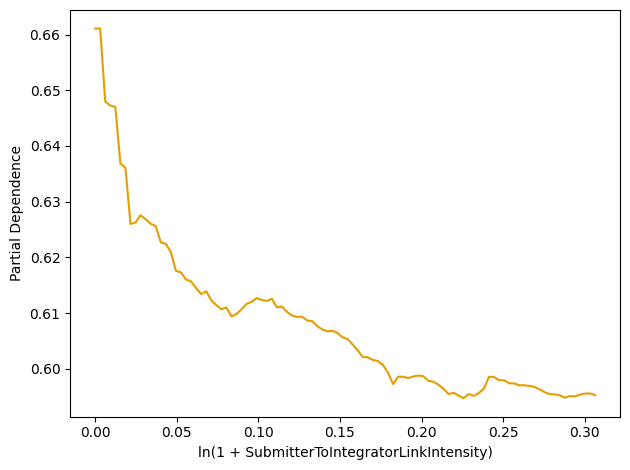

In [12]:
from python_proj.modelling.notebooks.random_forest.rf_functions import create_model
from python_proj.modelling.notebooks.random_forest.pd_functions import (
    create_partial_dependence_plots,
)

full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

output_path = f"{figure_base_path}/partial-dependence/"
create_partial_dependence_plots(full_rf_model, test_predictors, output_path)

### Mean decrease in Impurity

/tmp/ipykernel_1930/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


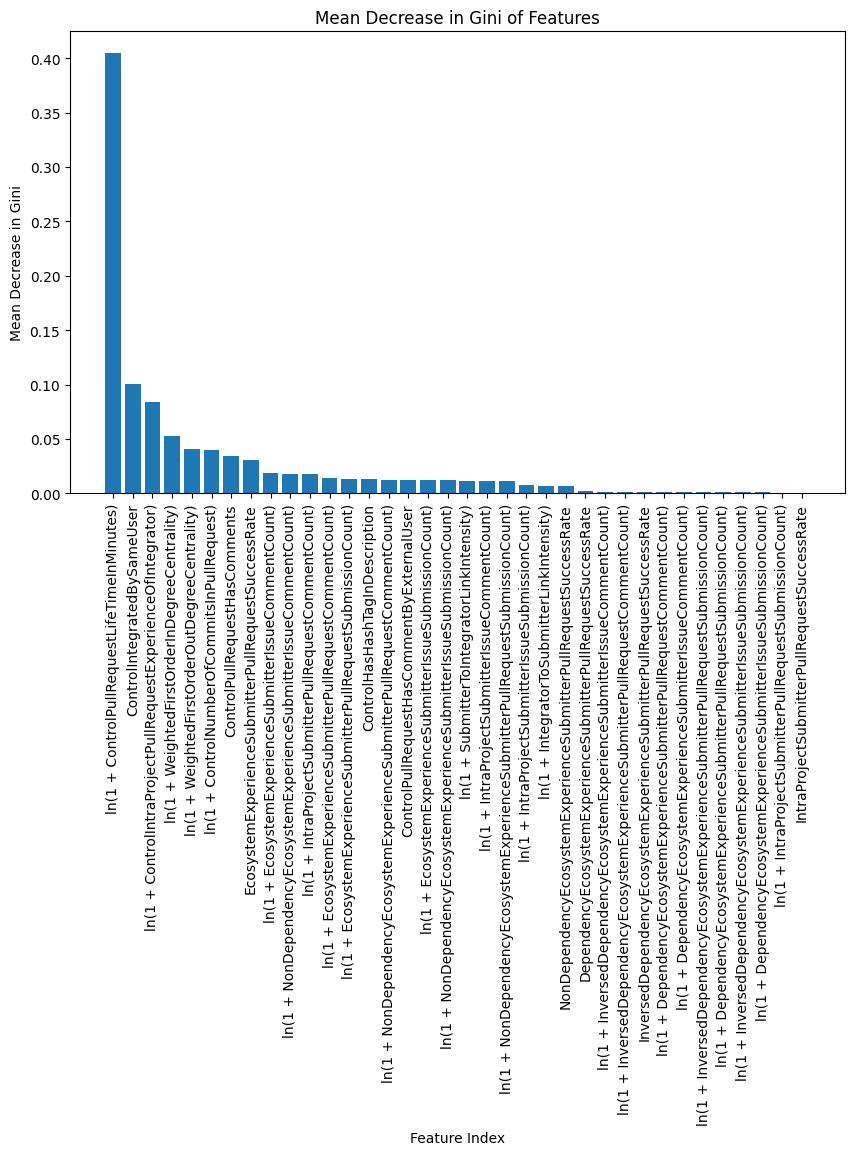

In [13]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [14]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.4044133011489917
ControlIntegratedBySameUser: 0.10080666852030226
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.08436170017177874
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.05307993952812817
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.04070954990090214
ln(1 + ControlNumberOfCommitsInPullRequest): 0.040074041287542425
ControlPullRequestHasComments: 0.03453731788653256
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.030674349943199158
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.018332201790689954
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.017432977841966974
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.01736252302585794
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.013976707927873916
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.013391504332699774
ControlHasHashTagInDescription: 0.013079453613004855
ln(1 + NonDependencyEco

### Variable Group Ablation Studies

Performs an ablation and a reverse ablation study using different feature groups:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [15]:
from python_proj.utils.util import get_matching

# Generates variable groups

var_group_regex_patterns = [
    ("control", r".*Control.*"),
    ("intra", r"^(?!.*Control).*(?=Intra).*"),
    ("eco", r"^(?!.*Dependency).*(?=Ecosystem).*"),
    ("deco", r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    ("ideco", r".*(?=Inverse).*"),
    ("ndeco", r".*(?=NonDependency).*"),
    ("coll", r".*(Weighted|LinkIntensity).*"),
]

var_groups = [
    (name, list(get_matching(independent_fields, pattern)))
    for name, pattern in var_group_regex_patterns
]

#### Regular Ablation
Creates models with subsets of the features to test their impact on the predictions in isolation.

In [16]:
abl_results = dict()

for cluster_name, cluster in var_groups:
    used_fields = list([field for field in independent_fields if field not in cluster])
    print(
        f'Ablation with "{cluster_name}", excluding: {list(cluster)}, including: {used_fields}.'
    )

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, used_fields, k, pr_merged_key, seed_counter
    )
    abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Ablation with "control", excluding: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'], including: ['IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosys

random_state=50
random_state=50
random_state=50
metrics={'accuracy': 0.6446070968497483, 'precision': 0.6627483027407594, 'recall': 0.9373721926845315, 'f1': 0.7764938097026741}

Confusion matrix:
[[ 2328 26825]
 [ 3522 52715]]

Classification report:
              precision    recall  f1-score   support

       False       0.40      0.08      0.13     29153
        True       0.66      0.94      0.78     56237

    accuracy                           0.64     85390
   macro avg       0.53      0.51      0.45     85390
weighted avg       0.57      0.64      0.56     85390

metrics={'accuracy': 0.6472771987352149, 'precision': 0.6651588258946521, 'recall': 0.9384650841207651, 'f1': 0.7785221080806818}

Confusion matrix:
[[ 2335 26648]
 [ 3471 52936]]

Classification report:
              precision    recall  f1-score   support

       False       0.40      0.08      0.13     28983
        True       0.67      0.94      0.78     56407

    accuracy                           0.65     85390

In [21]:
# Prints summarized results again for clarity.
print("Regular cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Regular cluster ablation results:
Cluster 'control':
f1_scores=[0.7764938097026741, 0.7785221080806818, 0.7773642635442256, 0.7741845039142337, 0.7769054749063725]
f1_mean=0.7766940320296375, f1_std=0.0014264361719956286

Cluster 'intra':
f1_scores=[0.8287808015163823, 0.8272886040320802, 0.8294360733873626, 0.827480967802099, 0.8277106290709197]
f1_mean=0.8281394151617688, f1_std=0.0008287326499478898

Cluster 'eco':
f1_scores=[0.8309400857005216, 0.8346304981619977, 0.8329598782395468, 0.8325680897660299, 0.8317496280265115]
f1_mean=0.8325696359789216, f1_std=0.0012431646312725322

Cluster 'deco':
f1_scores=[0.8342772258843191, 0.8322927843064367, 0.8315886413369494, 0.8308221324457319, 0.8303894120641384]
f1_mean=0.8318740392075151, f1_std=0.0013669477821993418

Cluster 'ideco':
f1_scores=[0.8325952020052333, 0.8325195024246258, 0.8324340755376548, 0.8317084729697709, 0.832254607618837]
f1_mean=0.8323023721112243, f1_std=0.0003178799614032899

Cluster 'ndeco':
f1_scores=[0.832678778

#### Reverse ablation

Performs a reverse ablation study, such that models are created using ONLY the subset of variables.

In [17]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups:
    print(f'Reverse ablation with "{cluster_name}", including: {list(cluster)}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=64
random_state=64
random_state=64
random_state=64random_state=64

metrics={'accuracy': 0.7257055861342078, 'precision': 0.7761778789806785, 'recall': 0.821775508757002, 'f1': 0.7983261292600182}

Confusion matrix:
[[15610 13368]
 [10054 46358]]

Classification report:
              precision    recall  f1-score   support

       False       0.61      0.54      0.57     28978
        True       0.78      0.82      0.80     56412

    accuracy                           0.73     85390
   macro avg       0.69      0.68      0.68     85390
weighted avg       0.72      0.73      0.72     85390

metrics={'accuracy': 0.7228481086778311, 'precision': 0.7724012239369974, 'recall': 0.8212590446052375, 'f1': 0.7960812021782587}

Confusion matrix:
[[15529 13612]
 [10054 46195]]

Classification report:
              precision    recall  f1-score   support

       False       0.61      0.53      0.57     29141
        True       0.77      0.82      0.80     56249

    accuracy          

In [20]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'control':
f1_scores=[0.7983261292600182, 0.7960812021782587, 0.7961225549593214, 0.7959519968250957, 0.7963164721141375]
f1_mean=0.7965596710673662, f1_std=0.0008909311120074406

Cluster 'intra':
f1_scores=[0.7946511151747072, 0.7929610723830263, 0.7933191498384919, 0.7926142792486989, 0.79276501866727]
f1_mean=0.7932621270624388, f1_std=0.0007334844291902667

Cluster 'eco':
f1_scores=[0.7830763559083121, 0.7821131399514618, 0.782431465514126, 0.7809164006918963, 0.7829252963655933]
f1_mean=0.7822925316862778, f1_std=0.0007694143314463672

Cluster 'deco':
f1_scores=[0.7938464147663432, 0.7926012378426172, 0.7938607648605105, 0.7929008308290615, 0.793619382151515]
f1_mean=0.7933657260900094, f1_std=0.0005178872984435871

Cluster 'ideco':
f1_scores=[0.7931697931697932, 0.7931278380557638, 0.7928209626757973, 0.7939020856450233, 0.7923585453207059]
f1_mean=0.7930758449734168, f1_std=0.0005047151610661227

Cluster 'ndeco':
f1_scores=[0.78516159709

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [18]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.6581168755123551.
{
    "accuracy": 0.5503923176015927,
    "precision": 0.6578698667998074,
    "recall": 0.657658781796467,
    "f1": 0.6577643073631663
}


In [19]:
import datetime

print(datetime.datetime.now())

2024-01-31 12:58:53.895762
